In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("chatgpt-reddit-comments.csv")

# EXPLORATORY DATA ANALYSIS

In [3]:
df.head()

,Unnamed: 0,comment_id,comment_parent_id,comment_body,subreddit
0,0,iztdxuh,t3_zj2aeu,"I've been shocked for days now, I don't need c...",r/ChatGPT
1,1,iztn0q0,t3_zj2aeu,\n\nI am so angry right now. I just wasted my...,r/ChatGPT
2,2,izudrph,t3_zj2aeu,chatgpt karma whoring is here folks! just when...,r/ChatGPT
3,3,iztfhtb,t3_zj2aeu,"Worked on me, ngl.",r/ChatGPT
4,4,izu2as9,t3_zj2aeu,"Certified 10/10, must-see moment. It really di...",r/ChatGPT


In [4]:
print(df.shape)
df.info()

(52416, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52416 entries, 0 to 52415
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         52413 non-null  object
 1   comment_id         52415 non-null  object
 2   comment_parent_id  52415 non-null  object
 3   comment_body       52415 non-null  object
 4   subreddit          52415 non-null  object
dtypes: object(5)
memory usage: 2.0+ MB


In [5]:
print(df.isnull().sum())

Unnamed: 0           3
comment_id           1
comment_parent_id    1
comment_body         1
subreddit            1
dtype: int64


In [6]:
print(df['subreddit'].value_counts())

subreddit
r/ChatGPT            29711
r/technology         16672
r/Futurology          5009
r/dataisbeautiful     1020
subreddit                3
Name: count, dtype: int64


In [7]:
print(df.subreddit.unique())

['r/ChatGPT' 'subreddit' 'r/dataisbeautiful' 'r/Futurology' 'r/technology'
 nan]


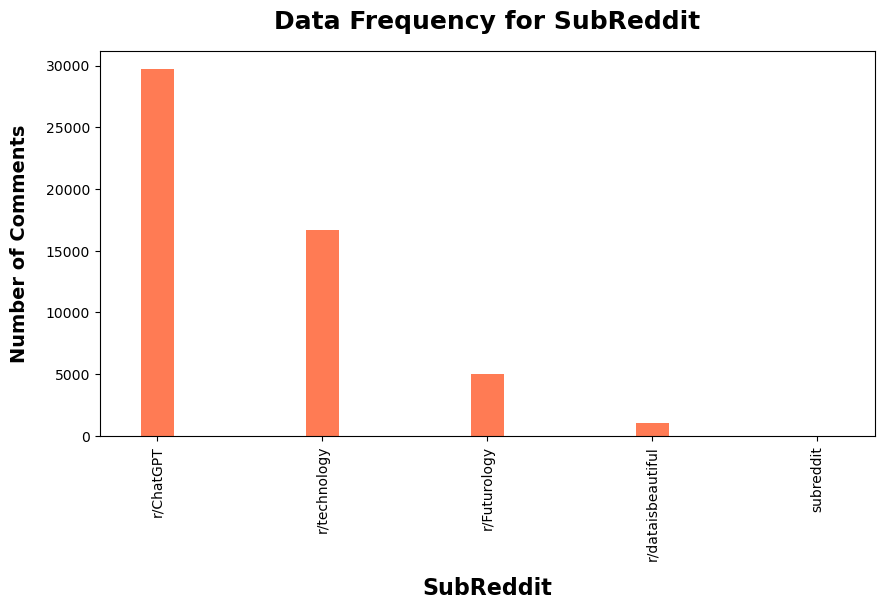

In [8]:
from matplotlib import pyplot as plt

df['subreddit'].value_counts().sort_values(ascending = False).plot(kind='bar', figsize=(10,5), width=0.2, color="#FF7B54")

plt.xlabel("SubReddit", fontsize=16, fontweight="semibold", labelpad=12)
plt.ylabel("Number of Comments", fontsize=14, fontweight="semibold", labelpad=12)
plt.title("Data Frequency for SubReddit", fontsize=18,pad=16, fontweight="bold")

plt.show()

# TEXT ANALYSIS, MORE VISUALIZATION & PREPROCESSING

## Preprocessing Text

In [4]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import pandas as pd
from tqdm import tqdm

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\shriv\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shriv\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\shriv\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [6]:
def preprocess_text(text):
    # 1. Ensure input is a string to handle potential NaNs
    text = str(text)
    
    # 2. Lowercase and remove special characters/numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)
    text = text.lower().strip()
    
    # 3. Tokenize
    tokens = nltk.word_tokenize(text)
    
    # 4. Remove stopwords and lemmatize
    processed_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    
    return " ".join(processed_tokens)

In [7]:
tqdm.pandas(desc="Cleaning Comments")
df['processed_comment'] = df['comment_body'].progress_apply(preprocess_text)

print("Text preprocessing complete.")
print("\nSample of Original vs. Processed Comments:")
print(df[['comment_body', 'processed_comment']].head())

Cleaning Comments: 100%|███████████████████████████████████████████████████████| 52416/52416 [00:16<00:00, 3186.68it/s]

Text preprocessing complete.

Sample of Original vs. Processed Comments:
                                        comment_body  \
0  I've been shocked for days now, I don't need c...   
1   \n\nI am so angry right now. I just wasted my...   
2  chatgpt karma whoring is here folks! just when...   
3                                 Worked on me, ngl.   
4  Certified 10/10, must-see moment. It really di...   

                                   processed_comment  
0                ive shocked day dont need clickbait  
1  angry right wasted time reading post sub click...  
2  chatgpt karma whoring folk think stream though...  
3                                         worked ngl  
4         certified mustsee moment really shock core  


# TF-IDF Vectorization

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

print("\n--- Step 3: Converting Text to Numerical Vectors ---")

vectorizer = TfidfVectorizer(max_features=1000, # Consider the top 1000 most frequent words
                             ngram_range=(1, 2)) # Include both single words and two-word phrases

tfidf_matrix = vectorizer.fit_transform(df['processed_comment'])

print("TF-IDF matrix created successfully.")
print(f"Matrix shape: {tfidf_matrix.shape} (comments, features/words)")


--- Step 3: Converting Text to Numerical Vectors ---
TF-IDF matrix created successfully.
Matrix shape: (52416, 1000) (comments, features/words)


# Importing Libraries SSE FOR KMEANS & PLOTING

In [18]:
from sklearn.cluster import KMeans
from tqdm import tqdm
import matplotlib.pyplot as plt

In [19]:
print("--- Calculating SSE for Different Numbers of Clusters (K) ---")

sse_values = []
k_range = range(2, 11) # Test k from 2 to 10

for k in tqdm(k_range, desc="Calculating SSE"):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(tfidf_matrix)
    # The 'inertia_' attribute of the fitted KMeans model is the SSE value.
    sse_values.append(kmeans.inertia_)

--- Calculating SSE for Different Numbers of Clusters (K) ---


Calculating SSE: 100%|███████████████████████████████████████████████████████████████████| 9/9 [00:20<00:00,  2.32s/it]


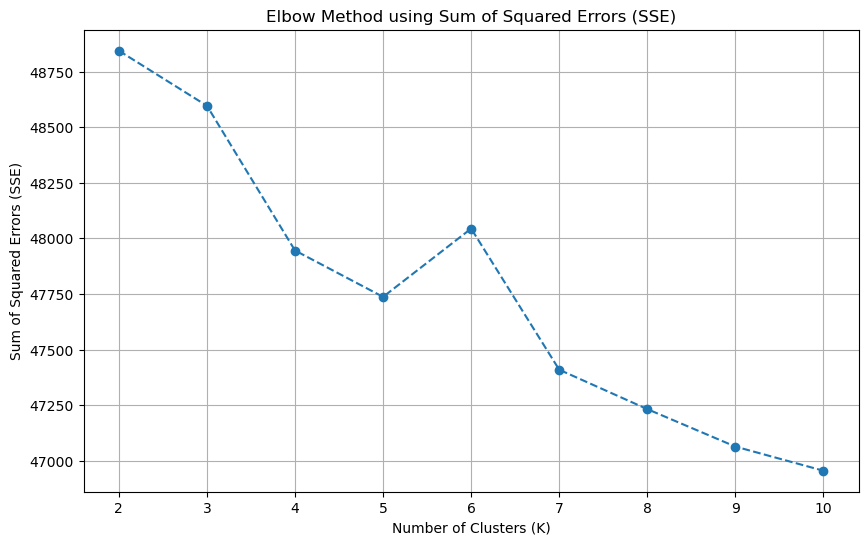

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(k_range, sse_values, marker='o', linestyle='--')
plt.title('Elbow Method using Sum of Squared Errors (SSE)')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.xticks(k_range)
plt.grid(True)
plt.show()

# I am choosing K= 5

In [21]:
optimal_k = 5
print(f"\n--- Step 5: Applying K-Means with K={optimal_k} ---")

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans.fit(tfidf_matrix)

# Add the cluster labels to our DataFrame
df['cluster'] = kmeans.labels_

print("K-Means clustering complete. Analyzing clusters...")


--- Step 5: Applying K-Means with K=5 ---
K-Means clustering complete. Analyzing clusters...


In [22]:
# --- Analyze the Clusters by Finding Top Terms ---
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

for i in range(optimal_k):
    print(f"\nCluster {i} Top Terms:")
    top_terms = [terms[ind] for ind in order_centroids[i, :10]] # Get top 10 terms
    print(" | ".join(top_terms))


Cluster 0 Top Terms:
get | im | people | dont | thats | would | one | good | make | work

Cluster 1 Top Terms:
chatgpt | google | use | like | answer | would | using | get | write | ask

Cluster 2 Top Terms:
deleted | kill | sorry | oh | comment | someone | take | dont | friend | free

Cluster 3 Top Terms:
ai | like | people | would | human | think | thing | dont | make | get

Cluster 4 Top Terms:
lol | like | im | thats | chatgpt | one | yeah | dont | good | ai


C:\Users\shriv\AppData\Local\Temp\ipykernel_10304\1549481450.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='cluster', data=df, palette='viridis')


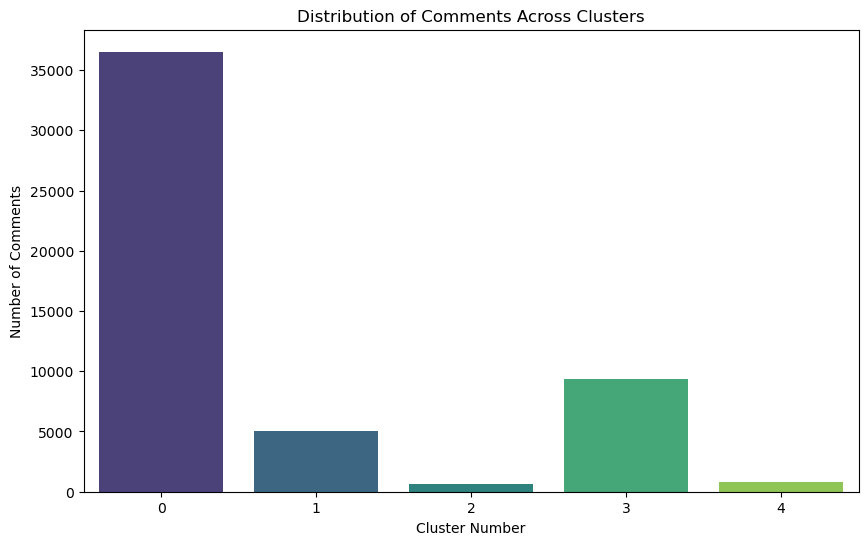

In [26]:
plt.figure(figsize=(10, 6))
sns.countplot(x='cluster', data=df, palette='viridis')
plt.title('Distribution of Comments Across Clusters')
plt.xlabel('Cluster Number')
plt.ylabel('Number of Comments')
plt.show(

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

In [24]:
# --- Step 7: Visualize Clusters and Create Summary Table ---

# 1. Dimensionality Reduction for Plotting using PCA
print("\n--- Reducing dimensions for visualization ---")
pca = PCA(n_components=2, random_state=42)
# We need .toarray() because PCA works with dense matrices
reduced_features = pca.fit_transform(tfidf_matrix.toarray())

# Create a DataFrame for the reduced data
df_plot = pd.DataFrame(reduced_features, columns=['PCA1', 'PCA2'])
df_plot['cluster'] = kmeans.labels_


--- Reducing dimensions for visualization ---


--- Generating cluster plot ---
Cluster visualization saved as 'cluster_visualization.png'


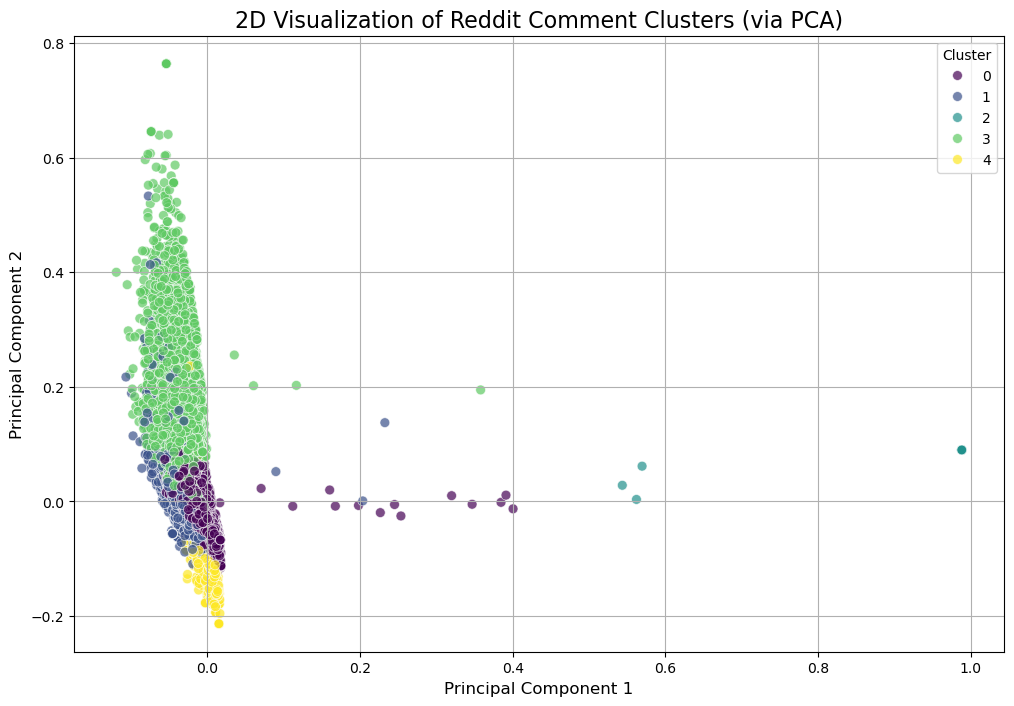

In [25]:
# 2. Create the Scatter Plot
print("--- Generating cluster plot ---")
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=df_plot,
    x='PCA1',
    y='PCA2',
    hue='cluster',
    palette='viridis', # You can try other palettes like 'plasma' or 'magma'
    alpha=0.7,
    s=50 # marker size
)
plt.title('2D Visualization of Reddit Comment Clusters (via PCA)', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.legend(title='Cluster')
plt.grid(True)
plt.savefig('cluster_visualization.png')
print("Cluster visualization saved as 'cluster_visualization.png'")

### The public discourse on ChatGPT is organized into distinct, identifiable themes like jobs, ethics, and technical capabilities.

In [26]:
# 3. Create a Summary Table
print("\n--- Generating summary table ---")
summary_data = []
terms = vectorizer.get_feature_names_out()
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]

# You need to fill in the 'Inferred Topic' based on your interpretation
# of the keywords from the previous step. Below are likely examples.
topic_interpretations = {
    0: "Impact on Jobs & Future of Work",
    1: "Technical Aspects & Model Capabilities",
    2: "Ethical Concerns & AI Behavior",
    3: "Creative Uses & Prompt Engineering",
    4: "General Discussion & User Experience"
    # NOTE: Your actual cluster topics may vary! Update these.
}


for i in range(optimal_k):
    top_terms = [terms[ind] for ind in order_centroids[i, :10]]
    cluster_size = df[df['cluster'] == i].shape[0]
    
    summary_data.append({
        'Cluster ID': i,
        'Inferred Topic': topic_interpretations.get(i, "Topic not defined"),
        'Top Keywords': ", ".join(top_terms),
        'Number of Comments': cluster_size
    })

df_summary = pd.DataFrame(summary_data)

# Display the table in a clean format
print("\n--- Cluster Summary Table ---")
print(df_summary.to_markdown(index=False))

# Save the summary table to a CSV file
df_summary.to_csv('cluster_summary.csv', index=False)
print("\nSummary table saved as 'cluster_summary.csv'")


--- Generating summary table ---

--- Cluster Summary Table ---
|   Cluster ID | Inferred Topic                         | Top Keywords                                                         |   Number of Comments |
|-------------:|:---------------------------------------|:---------------------------------------------------------------------|---------------------:|
|            0 | Impact on Jobs & Future of Work        | get, im, people, dont, thats, would, one, good, make, work           |                36531 |
|            1 | Technical Aspects & Model Capabilities | chatgpt, google, use, like, answer, would, using, get, write, ask    |                 5031 |
|            2 | Ethical Concerns & AI Behavior         | deleted, kill, sorry, oh, comment, someone, take, dont, friend, free |                  664 |
|            3 | Creative Uses & Prompt Engineering     | ai, like, people, would, human, think, thing, dont, make, get        |                 9346 |
|            4 | Genera

# Hierarchial clustering

In [29]:
df.head()

,Unnamed: 0,comment_id,comment_parent_id,comment_body,subreddit,processed_comment,cluster
0,0,iztdxuh,t3_zj2aeu,"I've been shocked for days now, I don't need c...",r/ChatGPT,ive shocked day dont need clickbait,0
1,1,iztn0q0,t3_zj2aeu,\n\nI am so angry right now. I just wasted my...,r/ChatGPT,angry right wasted time reading post sub click...,1
2,2,izudrph,t3_zj2aeu,chatgpt karma whoring is here folks! just when...,r/ChatGPT,chatgpt karma whoring folk think stream though...,1
3,3,iztfhtb,t3_zj2aeu,"Worked on me, ngl.",r/ChatGPT,worked ngl,0
4,4,izu2as9,t3_zj2aeu,"Certified 10/10, must-see moment. It really di...",r/ChatGPT,certified mustsee moment really shock core,0


In [ ]:
n*(n-1)/2
(52,416 * 52,415) / 2 = ~1.37 billion unique pairs.

#### Dendogram to find Optimal no.of Clusters

--- Creating a sample of 5000 comments ---
--- Vectorizing the sampled data using TF-IDF ---
--- Generating linkage matrix for the sample ---
--- Plotting the truncated dendrogram ---


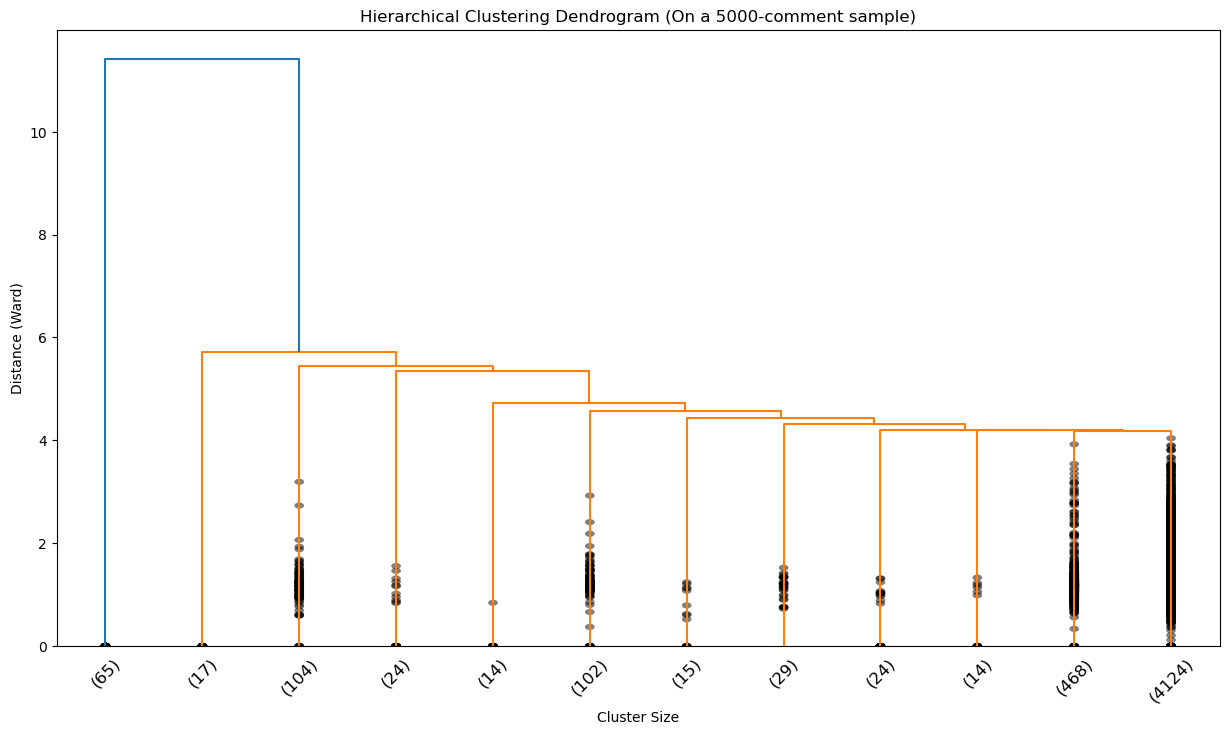

In [11]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy.cluster.hierarchy as sch
from matplotlib import pyplot as plt

# --- Assume 'df' is your pre-existing DataFrame ---
# If you are starting in a new script, you would first need to load and 
# preprocess your data to create the 'df' DataFrame with the 
# 'processed_comment' column.

# --- Step 1: Create a random sample of 5000 comments ---
print("--- Creating a sample of 5000 comments ---")
df_sample = df.sample(n=5000, random_state=42)

# --- Step 2: Vectorize ONLY the sampled text data ---
print("--- Vectorizing the sampled data using TF-IDF ---")
vectorizer_sample = TfidfVectorizer(stop_words='english', max_features=1000)
tfidf_matrix_sample = vectorizer_sample.fit_transform(df_sample['processed_comment'])
tfidf_dense_sample = tfidf_matrix_sample.toarray()

# --- Step 3: Run hierarchical clustering on the SMALLER dense matrix ---
print("--- Generating linkage matrix for the sample ---")
# The 'ward' method minimizes the variance within each cluster.
linked_data_sample = sch.linkage(tfidf_dense_sample, method='ward', metric='euclidean')

# --- Step 4: Plot the Dendrogram ---
print("--- Plotting the truncated dendrogram ---")
plt.figure(figsize=(15, 8))

# We truncate the dendrogram to make it readable with a large sample size.
# 'lastp' shows the last 'p' merged clusters.
sch.dendrogram(linked_data_sample,
               truncate_mode='lastp',
               p=12,  # Show the last 12 merged clusters
               leaf_rotation=45.,
               leaf_font_size=12.,
               show_contracted=True) # Shows cluster sizes in parentheses

plt.title('Hierarchical Clustering Dendrogram (On a 5000-comment sample)')
plt.xlabel('Cluster Size')
plt.ylabel('Distance (Ward)')
plt.show()

### Here can make 2 clusters
### i) Blue
### ii) Orange

In [17]:
import pandas as pd
from sklearn.cluster import AgglomerativeClustering

# This assumes 'df_sample', 'tfidf_dense_sample', and 'vectorizer_sample'
# from the previous dendrogram step already exist.

# --- Step 1: Apply Hierarchical Clustering with n_clusters=2 ---
print("--- Applying Hierarchical Clustering to create 2 groups ---")
hc = AgglomerativeClustering(n_clusters=2, metric='euclidean', linkage='ward')

# Get the cluster labels (0 or 1) for each comment in the sample
hc_labels_2_groups = hc.fit_predict(tfidf_dense_sample)

# Optional: Add these labels to your sample DataFrame to see them
df_sample['hierarchical_cluster_2'] = hc_labels_2_groups


# --- Step 2: Find the Top Keywords for Each of the 2 Groups ---
print("\n--- Finding Top Keywords for the 2 Main Groups ---")
terms = vectorizer_sample.get_feature_names_out()

# Loop through each of the two clusters (0 and 1)
for i in range(2):
    # Get all the TF-IDF vectors belonging to the current cluster
    cluster_vectors = tfidf_dense_sample[hc_labels_2_groups == i]
    mean_vector = cluster_vectors.mean(axis=0)# Calculate the mean vector for the cluster
    top_term_indices = mean_vector.argsort()[::-1][:10] # Get the indices of the top 10 most important word
    top_terms = [terms[ind] for ind in top_term_indices] # Map the indices back to the actual words

    print(f"\n--- Top Keywords for Group {i} ---")
    print(" | ".join(top_terms))

--- Applying Hierarchical Clustering to create 2 groups ---

--- Finding Top Keywords for the 2 Main Groups ---

--- Top Keywords for Group 0 ---
ai | like | chatgpt | people | dont | im | thing | make | use | know

--- Top Keywords for Group 1 ---
deleted | zero | fuck | friend | free | formula | form | forget | forced | force


In [19]:
import pandas as pd

# This assumes 'df_sample', 'tfidf_dense_sample', 'vectorizer_sample', 
# and 'hc_labels_2_groups' from the previous steps already exist.

summary_data_hierarchical = []
terms = vectorizer_sample.get_feature_names_out()

# Define your interpretations for the two main topics
topic_interpretations_hierarchical = {
    0: "General Discourse & Societal Impact",
    1: "Technical Functionality & Specifics"
}

print("--- Generating Summary Table for 2 Hierarchical Groups ---")

# Loop through the two clusters (0 and 1)
for i in range(2):
    # Calculate the mean vector for the current cluster
    cluster_vectors = tfidf_dense_sample[hc_labels_2_groups == i]
    mean_vector = cluster_vectors.mean(axis=0)
    
    # Get the top 10 keywords
    top_term_indices = mean_vector.argsort()[::-1][:10]
    top_terms = [terms[ind] for ind in top_term_indices]
    
    # Get the number of comments in this cluster from the sample DataFrame
    cluster_size = df_sample[df_sample['hierarchical_cluster_2'] == i].shape[0]
    
    summary_data_hierarchical.append({
        'Group ID': i,
        'Inferred Topic': topic_interpretations_hierarchical.get(i, "N/A"),
        'Top Keywords': ", ".join(top_terms),
        'Number of Comments (in sample)': cluster_size
    })

# Create the summary DataFrame
df_summary_hierarchical = pd.DataFrame(summary_data_hierarchical)

# Save the summary to a CSV file for your records
df_summary_hierarchical.to_csv('hierarchical_cluster_summary_2_groups.csv', index=False)
print("Summary table saved to 'hierarchical_cluster_summary_2_groups.csv'")

# --- Display the DataFrame as a formatted table in the Jupyter Notebook output ---
# By placing the DataFrame name as the last line, Jupyter will render it neatly.
df_summary_hierarchical

--- Generating Summary Table for 2 Hierarchical Groups ---
Summary table saved to 'hierarchical_cluster_summary_2_groups.csv'


,Group ID,Inferred Topic,Top Keywords,Number of Comments (in sample)
0,0,General Discourse & Societal Impact,"ai, like, chatgpt, people, dont, im, thing, ma...",4935
1,1,Technical Functionality & Specifics,"deleted, zero, fuck, friend, free, formula, fo...",65


--- Reducing dimensions for visualization ---
--- Generating scatter plot ---


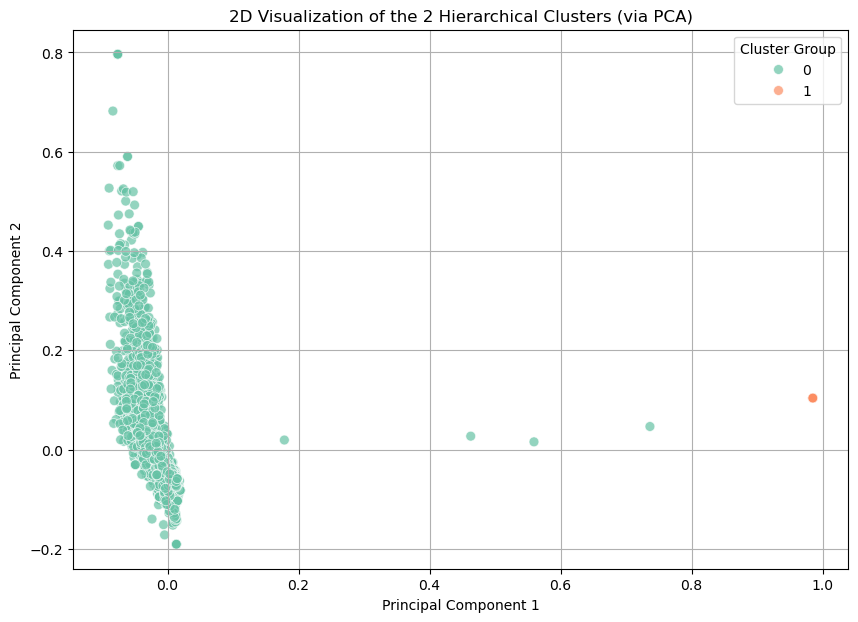

In [25]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# This assumes 'df_sample', 'tfidf_dense_sample', and the 'hierarchical_cluster_2'
# column from the previous steps already exist.

# --- Step 1: Reduce dimensions of the SAMPLE data using PCA ---
print("--- Reducing dimensions for visualization ---")
pca = PCA(n_components=2, random_state=42)
reduced_features_sample = pca.fit_transform(tfidf_dense_sample)

# --- Step 2: Create a DataFrame for plotting ---
df_plot_hierarchical = pd.DataFrame(reduced_features_sample, columns=['PCA1', 'PCA2'])
# Ensure correct cluster labels are aligned with the new plot DataFrame
df_plot_hierarchical['cluster'] = df_sample['hierarchical_cluster_2'].values

# --- Step 3: Create the Scatter Plot ---
print("--- Generating scatter plot ---")
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=df_plot_hierarchical,
    x='PCA1',
    y='PCA2',
    hue='cluster',
    palette='Set2', # Using the same color scheme for consistency
    alpha=0.7,
    s=50
)
plt.title('2D Visualization of the 2 Hierarchical Clusters (via PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster Group')
plt.grid(True)
plt.show()

--- 1. Generating k-distance graph to find optimal eps ---


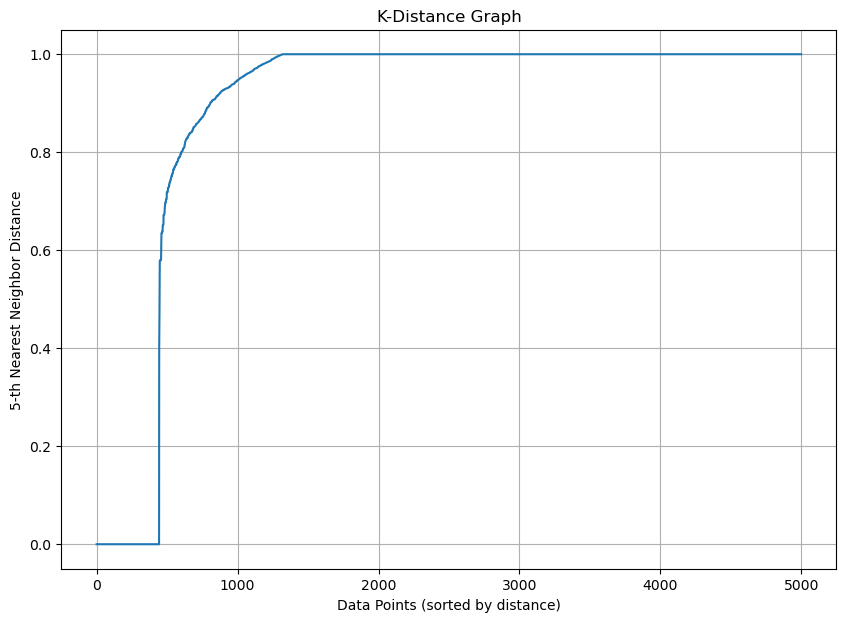


Based on the graph, we will use eps = 0.2

--- 2. Running DBSCAN clustering ---

DBSCAN algorithm complete.
Estimated number of clusters: 17
Estimated number of noise points: 4556


In [33]:
# FILE 1: DBSCAN_ALGORITHM.py

import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from matplotlib import pyplot as plt

# --- ASSUMPTIONS ---
# This code assumes you have already created and loaded:
# - 'df_sample': Your DataFrame with 5000 comments.
# - 'tfidf_dense_sample': The dense TF-IDF matrix for the sample.

# --- Step 1: Find the Optimal `eps` Value ---
print("--- 1. Generating k-distance graph to find optimal eps ---")
min_samples = 5
neigh = NearestNeighbors(n_neighbors=min_samples)
nbrs = neigh.fit(tfidf_dense_sample)
distances, indices = nbrs.kneighbors(tfidf_dense_sample)
k_distances = sorted(distances[:, min_samples-1])

# Plotting the k-distance graph
plt.figure(figsize=(10, 7))
plt.plot(k_distances)
plt.title('K-Distance Graph')
plt.xlabel('Data Points (sorted by distance)')
plt.ylabel(f'{min_samples}-th Nearest Neighbor Distance')
plt.grid(True)
plt.show()
# --- From the plot, find the "knee" and choose your eps value ---
eps_value = 0.2 # Adjust this value based on your plot's "knee"...............................................................................
print(f"\nBased on the graph, we will use eps = {eps_value}")


# --- Step 2: Run the DBSCAN Algorithm ---
print("\n--- 2. Running DBSCAN clustering ---")
dbscan = DBSCAN(eps=eps_value, min_samples=min_samples, metric='euclidean')
db_labels = dbscan.fit_predict(tfidf_dense_sample)

# Add the results back to the sample DataFrame
df_sample['dbscan_cluster'] = db_labels

# --- Step 3: Analyze the Output ---
n_clusters_ = len(set(db_labels)) - (1 if -1 in db_labels else 0)
n_noise_ = list(db_labels).count(-1)

print(f"\nDBSCAN algorithm complete.")
print(f"Estimated number of clusters: {n_clusters_}")
print(f"Estimated number of noise points: {n_noise_}")

--- Generating 2D scatter plot of DBSCAN clusters via PCA ---


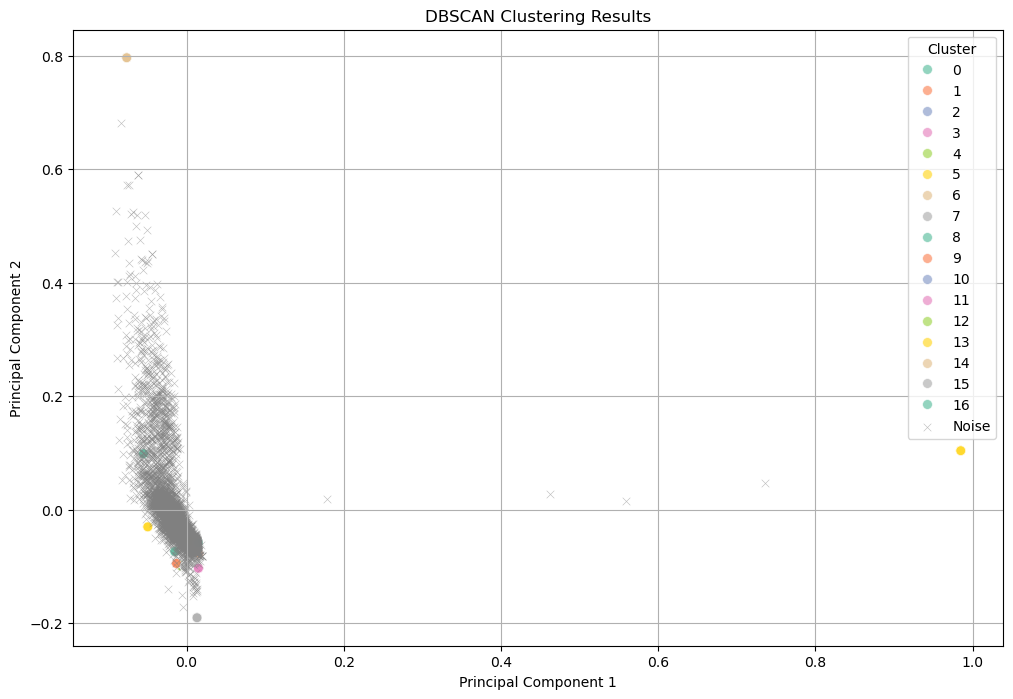

In [34]:
# FILE 2: PLOT_DBSCAN_CLUSTERS.py

import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# --- ASSUMPTIONS ---
# Run this after File 1. It assumes you have:
# - 'df_sample' with the 'dbscan_cluster' column.
# - 'tfidf_dense_sample': The dense TF-IDF matrix for the sample.

print("--- Generating 2D scatter plot of DBSCAN clusters via PCA ---")

# Reduce dimensions for visualization
pca = PCA(n_components=2, random_state=42)
reduced_features_sample = pca.fit_transform(tfidf_dense_sample)

# Create a DataFrame for plotting
df_plot_dbscan = pd.DataFrame(reduced_features_sample, columns=['PCA1', 'PCA2'])
df_plot_dbscan['cluster'] = df_sample['dbscan_cluster'].values

# Create the plot
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=df_plot_dbscan[df_plot_dbscan['cluster'] != -1],
    x='PCA1',
    y='PCA2',
    hue='cluster',
    palette='Set2',
    alpha=0.7,
    s=50
)
# Plot noise points separately in gray
sns.scatterplot(
    data=df_plot_dbscan[df_plot_dbscan['cluster'] == -1],
    x='PCA1',
    y='PCA2',
    color='gray',
    marker='x',
    label='Noise',
    alpha=0.5,
    s=30
)
plt.title('DBSCAN Clustering Results')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

In [35]:
# FILE 3: ANALYZE_DBSCAN_KEYWORDS.py

import pandas as pd
import numpy as np

# --- ASSUMPTIONS ---
# Run this after File 1. It assumes you have:
# - 'df_sample' with the 'dbscan_cluster' column.
# - 'tfidf_dense_sample': The dense TF-IDF matrix for the sample.
# - 'vectorizer_sample': The TF-IDF vectorizer used on the sample.
# - 'db_labels': The labels array from the DBSCAN run.

print("--- Finding Top Keywords for Each DBSCAN Cluster ---")
terms = vectorizer_sample.get_feature_names_out()
n_clusters_ = len(set(db_labels)) - (1 if -1 in db_labels else 0)

# Loop through each found cluster (ignoring noise label -1)
for i in range(n_clusters_):
    print(f"\n--- Top Keywords for Cluster {i} ---")
    
    # Get all the vectors belonging to the current cluster
    cluster_vectors = tfidf_dense_sample[db_labels == i]
    
    # Calculate the mean vector
    mean_vector = cluster_vectors.mean(axis=0)
    
    # Get the top 10 term indices
    top_term_indices = mean_vector.argsort()[::-1][:10]
    
    # Map indices back to words
    top_terms = [terms[ind] for ind in top_term_indices]
    
    print(" | ".join(top_terms))

--- Finding Top Keywords for Each DBSCAN Cluster ---

--- Top Keywords for Cluster 0 ---
zero | fit | friend | free | formula | form | forget | forced | force | food

--- Top Keywords for Cluster 1 ---
bot | good | zero | fit | free | formula | form | forget | forced | force

--- Top Keywords for Cluster 2 ---
need | zero | fine | free | formula | form | forget | forced | force | food

--- Top Keywords for Cluster 3 ---
thats | zero | fine | free | formula | form | forget | forced | force | food

--- Top Keywords for Cluster 4 ---
discord | comment | bot | nowhttpsdiscordggnuefuec | subredditmessagecomposetorchatgpt | moderator | performed | repetitive | automatically | friendly

--- Top Keywords for Cluster 5 ---
deleted | zero | fuck | friend | free | formula | form | forget | forced | force

--- Top Keywords for Cluster 6 ---
dan | zero | fit | free | formula | form | forget | forced | force | food

--- Top Keywords for Cluster 7 ---
lol | zero | friendly | free | formula | form | f

In [38]:
# FILE 4 (Updated): CREATE_SUBMISSION_CSV.py

import pandas as pd

# --- ASSUMPTIONS ---
# Run this after File 1. It assumes you have:
# - 'df_sample': Your DataFrame with the 'dbscan_cluster' column.
# - 'eps_value': The epsilon value you used to run the DBSCAN algorithm.

# --- Step 1: Define the eps value used in this experiment ---
# In a real script, this value might be passed from the previous step.
# For this example, we'll set it here.
eps_value = 1.1 # Make sure this matches the eps used in your algorithm file!

print(f"--- Generating submission file for eps={eps_value} ---")

# --- Step 2: Prepare the submission DataFrame ---
# Select the original comment body and the new cluster label
df_submission = df_sample[['comment_body', 'dbscan_cluster']].copy()
df_submission.rename(columns={'comment_body': 'Comment', 'dbscan_cluster': 'ClusterID'}, inplace=True)

# --- Step 3: Save to a dynamic CSV file ---
# Create a filename that changes based on the eps value
filename = f"submission_eps_{eps_value}.csv"
df_submission.to_csv(filename, index=False)
print(f"'{filename}' has been created successfully.")


# --- Step 4: Show a preview of all clusters ---
print("\nFile preview (showing up to 3 examples from each cluster):")

# Group by the ClusterID and show the first few rows of each group
# We use .to_string() to ensure pandas doesn't truncate the output
preview = df_submission.groupby('ClusterID').head(3)
print(preview.to_string())

--- Generating submission file for eps=1.1 ---
'submission_eps_1.1.csv' has been created successfully.

File preview (showing up to 3 examples from each cluster):
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

--- Generating final visualization of cluster sizes ---


C:\Users\shriv\AppData\Local\Temp\ipykernel_14948\3931910490.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(
C:\Users\shriv\AppData\Local\Temp\ipykernel_14948\3931910490.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticklabels, rotation=45, ha='right')


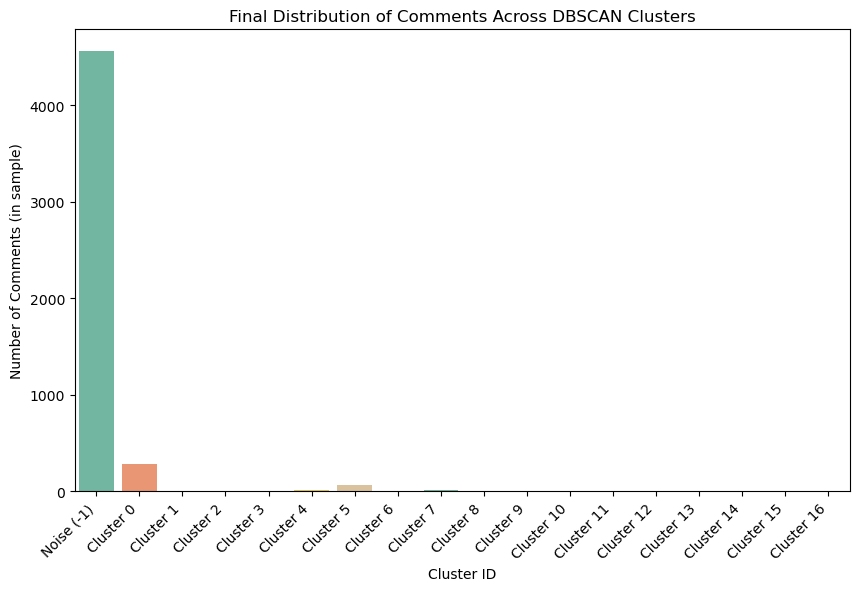

In [36]:
# FILE 5: PLOT_FINAL_VISUALIZATION.py

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- ASSUMPTIONS ---
# Run this after File 1. It assumes you have:
# - 'df_sample': Your DataFrame with the 'dbscan_cluster' column.

print("--- Generating final visualization of cluster sizes ---")

plt.figure(figsize=(10, 6))
ax = sns.countplot(
    data=df_sample,
    x='dbscan_cluster',
    palette='Set2',
    order=sorted(df_sample['dbscan_cluster'].unique()) # Ensure order
)

plt.title('Final Distribution of Comments Across DBSCAN Clusters')
plt.xlabel('Cluster ID')
plt.ylabel('Number of Comments (in sample)')

# Customize x-axis labels to clearly identify the noise cluster
xticklabels = [f'Cluster {label}' if label != -1 else 'Noise (-1)' for label in sorted(df_sample['dbscan_cluster'].unique())]
ax.set_xticklabels(xticklabels, rotation=45, ha='right')

plt.show()

In [ ]:
'''Here is a simple breakdown of what each of those five code files represents:

### ### 1. `DBSCAN_ALGORITHM.py`

This is the **core analysis engine**. Its job is to find the best settings for the DBSCAN algorithm (the `eps` value) and then run the clustering to group your comments, assigning a cluster ID to each one.

### ### 2. `PLOT_DBSCAN_CLUSTERS.py`

This is your **main cluster visualizer**. It creates the 2D scatter plot that shows you how the different clusters are positioned and separated from each other, and it specifically highlights which comments were identified as noise.

### ### 3. `ANALYZE_DBSCAN_KEYWORDS.py`

This is the **interpretation file**. Its purpose is to look inside each cluster and pull out the most important keywords, which helps you understand the *topic* or *meaning* of each group.

### ### 4. `CREATE_SUBMISSION_CSV.py`

This is the **results exporter**. It takes the final clustering results and saves them into a simple `submission.csv` file, pairing each comment with its assigned cluster ID for your records or for submission.

### ### 5. `PLOT_FINAL_VISUALIZATION.py`

This is your **summary graph generator**. It creates a final bar chart that gives you a quick, easy-to-read overview of how many comments are in each cluster and, importantly, how many were classified as noise.'''